# Ocean color reflectance

## Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils

plt.style.use("seaborn-v0_8-notebook")

## Define Parameters

In [2]:
# Time period
year_start = 1998
year_stop = 1999

# Variable to analyse
wavelength = 443
assert wavelength in (412, 443, 490, 510, 560, 665)

# Regions to plot
regions = {
    "global": {"lon_slice": slice(-180, 180), "lat_slice": slice(90, -90)},
    "15-30N 40-55W": {"lon_slice": slice(-55, -40), "lat_slice": slice(30, 15)},
    "NASTG": {"lon_slice": slice(-80, 0), "lat_slice": slice(50, 0)},
}

## Define request

In [3]:
collection_id = "satellite-ocean-colour"

request = {
    "variable": "remote_sensing_reflectance",
    "projection": "regular_latitude_longitude_grid",
    "version": "6_0",
    "format": "zip",
}

# Parameters to speed up I/O
open_mfdataset_kwargs = {
    "concat_dim": "time",
    "combine": "nested",
    "data_vars": "minimal",
    "coords": "minimal",
    "compat": "override",
    "parallel": True,
}

## Functions to cache

In [4]:
def rechunk(obj):
    chunks = {"year": 1, "longitude": 270, "latitude": 270}
    return obj.chunk(**{k: v for k, v in chunks.items() if k in obj.dims})


def rrs_monthly_weighted_log_reductions(ds, wavelength):
    name = f"Rrs_{wavelength}"
    da = rechunk(ds[name])
    weights = np.abs(np.cos(np.deg2rad(da["latitude"])))
    with xr.set_options(keep_attrs=True):
        da = np.log10(da)
        da = da.groupby("time.year").map(
            diagnostics.monthly_weighted_mean, weights=False
        )
        da = 10 ** (da + np.log10(weights))
        da = da.persist()
        da_mean = da.mean("month").expand_dims(reduction=["mean"])
        da_std = (10 ** np.log10(da).std("month")).expand_dims(reduction=["std"])
    da = xr.concat([da_mean, da_std], "reduction")
    da.encoding["chunksizes"] = tuple(map(max, da.chunks))
    return da.to_dataset(name=name)

## Download and transform data

In [5]:
datasets = []
for year in tqdm.tqdm(range(year_start, year_stop + 1), desc="year"):
    requests = download.update_request_date(
        request, start=f"{year}-01", stop=f"{year}-12", stringify_dates=True
    )
    ds = download.download_and_transform(
        collection_id,
        requests,
        transform_chunks=False,
        transform_func=rrs_monthly_weighted_log_reductions,
        transform_func_kwargs={"wavelength": wavelength},
        chunks={"year": 1, "month": 1},
        **open_mfdataset_kwargs,
    )
    datasets.append(rechunk(ds))
da_year = xr.concat(datasets, "year")[f"Rrs_{wavelength}"]

with xr.set_options(keep_attrs=True):
    da_mean = da_year.sel(reduction=["mean"]).mean("year")
    da_std = (da_year.sel(reduction=["std"]) ** 2).mean("year") ** 0.5
da = xr.concat([da_mean, da_std], "reduction")

year: 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]


## Plot maps

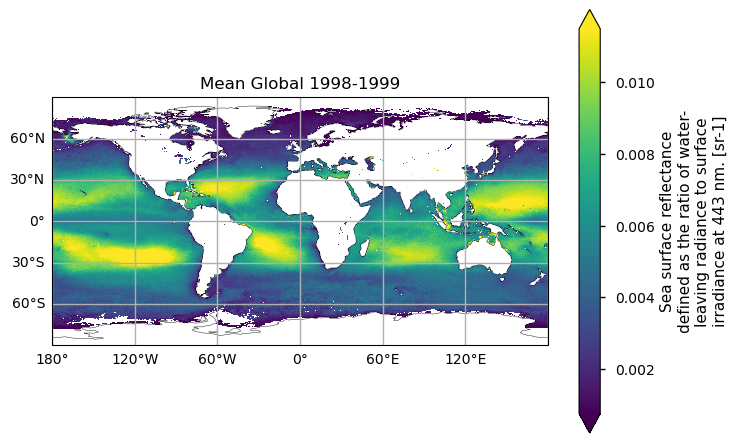

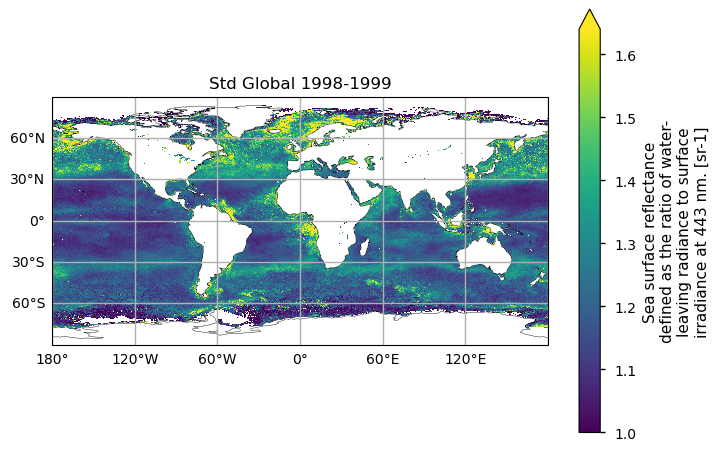

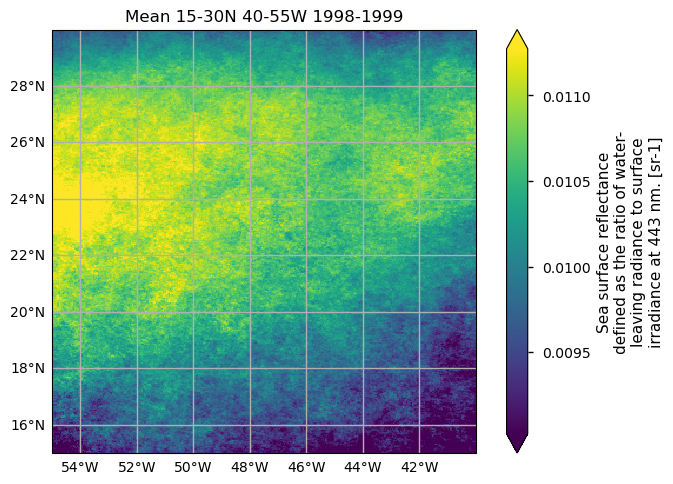

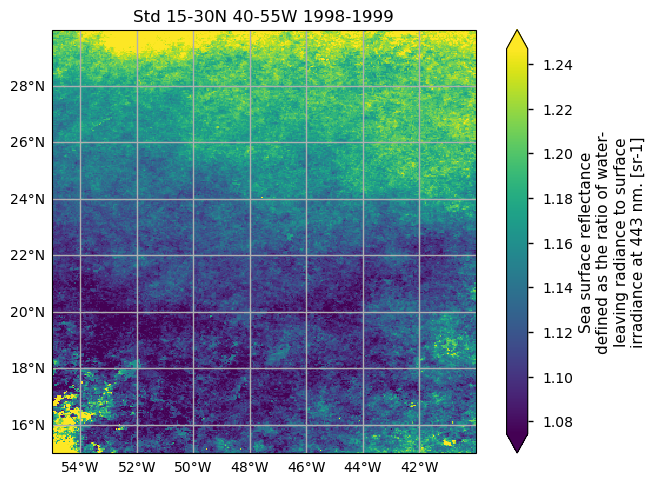

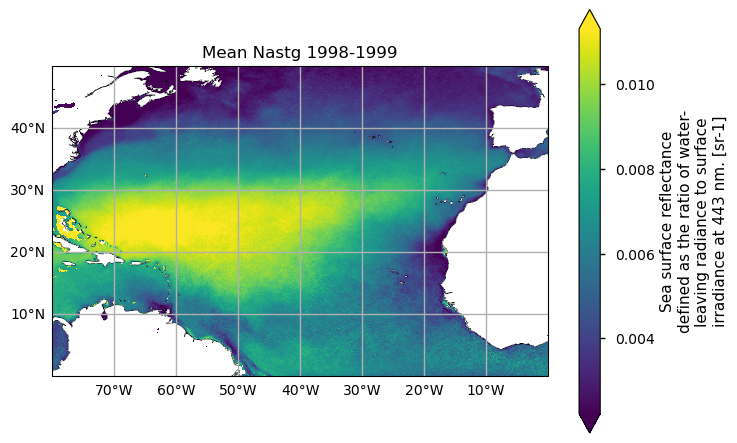

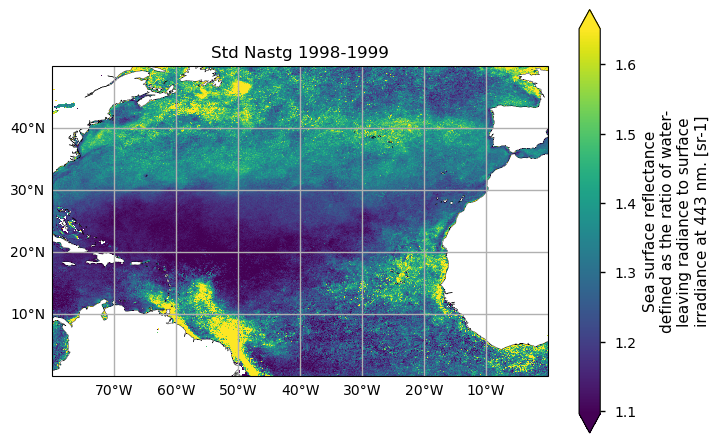

In [ ]:
for da_to_plot in [da, da_year]:
    for region, regionalise_kwargs in regions.items():
        da_region = utils.regionalise(da_to_plot, **regionalise_kwargs)
        for reduction, da_reduction in da_region.groupby("reduction"):
            plot.projected_map(
                da_reduction,
                col="year" if "year" in da_to_plot.dims else None,
                robust=True,
                show_stats=False,
            )
            title = [reduction.capitalize(), region, f"{year_start}-{year_stop}"]
            if "year" in da_to_plot.dims:
                title.append("yearly")
            title = " ".join(title)
            plt.suptitle(title) if "year" in da_to_plot.dims else plt.title(title)
            plt.savefig(title.replace(" ", "_").lower() + ".png")
            plt.show()